In [276]:
import numpy as np  # NumPy for numerical operations, such as arrays and mathematical functions
import pandas as pd  # Pandas for data manipulation and analysis, including reading CSV files
import scipy.stats as stats  # SciPy's stats module for statistical functions (e.g., distributions, hypothesis tests)
from scipy.stats import ttest_ind  # Importing t-test for independent samples from scipy.stats
import matplotlib.pyplot as plt  # Matplotlib for creating visualizations and plots
import seaborn as sns  # Seaborn for statistical data visualization, built on top of Matplotlib
from sklearn.model_selection import train_test_split  # Scikit-learn for splitting data into training and testing sets
import arviz as az  # ArviZ is a library for Exploratory Analysis of Bayesian Models.

data = pd.read_csv("data/checkout.csv")
data.head(20)

,Unnamed: 0,user_id,checkout_page,order_value,purchased,gender,browser,time_on_page
0,0,877621,A,29.410131,1.0,F,chrome,66.168628
1,1,876599,A,NaN,0.0,M,firefox,49.801887
2,2,905407,A,27.446845,1.0,M,chrome,56.744856
3,3,883562,A,30.602233,1.0,M,safari,71.890718
4,4,840542,A,29.668895,1.0,F,safari,67.410696
5,5,861142,A,22.556805,1.0,F,safari,33.272665
6,6,852680,A,27.375221,1.0,F,safari,56.401061
7,7,867863,A,NaN,0.0,M,safari,43.183714
8,8,873787,A,24.741953,1.0,M,safari,43.761374
9,9,890765,A,26.026496,1.0,M,safari,49.927182


In [277]:
# Split the dataset into prior and observed data
prior_data, observed_data = train_test_split(data, test_size=0.02, random_state=42)

# Summary of the splits
print(f"Size of the prior data: {prior_data.shape}")
print(f"Size of the observed data: {observed_data.shape}")

Size of the prior data: (8820, 8)
Size of the observed data: (180, 8)


In [278]:
def preprocessing_data(data):
    # Eliminate instances for Page C:
    data = data[data["checkout_page"] != "C"]
    
    print(data.info())
    
    # Fill missing values with 0
    data.fillna(0, inplace=True)
    
    # Count the number of values per checkout page
    checkout_page_count = data["checkout_page"].value_counts()
    print(f"The number of values by page: {checkout_page_count}")
    
    # Verify the number of instances for a single page:
    checkout_page_count = data.groupby("user_id")["checkout_page"].nunique().value_counts()
    print(checkout_page_count)
    
    # Create a dataset for single-page visitors:
    # Filtering users who visited only one checkout page
    single_page_customers = data.groupby("user_id")["checkout_page"].nunique()

    # Keep only the users who visited exactly one checkout page
    single_page_customers = single_page_customers[single_page_customers == 1]

    # Filter the original dataset to keep only users who visited a single page
    data_unique = data[data["user_id"].isin(single_page_customers.index)]
    
    # Keep only values greater than 0
    data_unique = data_unique[data_unique["order_value"] > 0]

    # Display the number of customers who visited only one checkout page
    print(f"Number of customers who visited only one checkout page: {data_unique['user_id'].nunique()}")
    
    # print(data_unique.head())
    
    # data_unique[data_unique["order_value"] == 0]
    
    print(data_unique["checkout_page"].value_counts())
    
    # --- BOX PLOT (formatation)
    # Set a refined Seaborn style
    sns.set(style="whitegrid")
    palette = ["#4C9EEB", "#FF9F57"] 

    # Create a boxplot for order values by checkout page
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data_unique, x="checkout_page", y="order_value", palette=palette, inner="quart", width=0.6)

    # Enhance title and labels
    plt.title('Order Value Distribution by Checkout Page', fontsize=16, fontweight='bold')
    plt.xlabel('Checkout Page', fontsize=14)
    plt.ylabel('Order Value', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # ---------- // ----
    # Summary statistics for each checkout page
    all_stat = data_unique.groupby(by="checkout_page").agg({'user_id': 'nunique',
                                                 'order_value': ["sum", "mean", "median", "std", 'count']})

    print(pd.DataFrame(all_stat))
    
    # Get order values for Page A
    page_a_order_value = data_unique[data_unique["checkout_page"] == "A"]["order_value"]
    # print(page_a_order_value.head())
    
    # Get order values for Page B
    page_b_order_value = data_unique[data_unique["checkout_page"] == "B"]["order_value"]
    # print(page_b_order_value.head())
    
    # Calculate the mean order values for both pages
    mean_a = np.mean(page_a_order_value)
    mean_b = np.mean(page_b_order_value)
    
    # Calculate the standard deviation for both pages
    std_a = np.std(page_a_order_value)
    std_b = np.std(page_b_order_value)
    
    # Count the number of order values for each page
    count_a = page_a_order_value.value_counts()
    count_b = page_b_order_value.value_counts()
    
    # Print the mean order value for each page
    print(f"The mean value of orders on Page A is ${mean_a}")
    print(f"The mean value of orders on Page B is ${mean_b}")
    
    return data_unique, page_a_order_value, page_b_order_value, mean_a, mean_b, std_a, std_b, count_a, count_b

<class 'pandas.core.frame.DataFrame'>
Index: 5886 entries, 3971 to 860
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     5886 non-null   int64  
 1   user_id        5886 non-null   int64  
 2   checkout_page  5886 non-null   object 
 3   order_value    4909 non-null   float64
 4   purchased      5886 non-null   float64
 5   gender         5886 non-null   object 
 6   browser        5886 non-null   object 
 7   time_on_page   5886 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 413.9+ KB
None
The number of values by page: checkout_page
B    2954
A    2932
Name: count, dtype: int64
checkout_page
1    5520
2     123
Name: count, dtype: int64
Number of customers who visited only one checkout page: 4619
checkout_page
B    2408
A    2304
Name: count, dtype: int64


C:\Users\danrl\AppData\Local\Temp\ipykernel_2392\3279332595.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)
C:\Users\danrl\AppData\Local\Temp\ipykernel_2392\3279332595.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_unique, x="checkout_page", y="order_value", palette=palette, inner="quart", width=0.6)


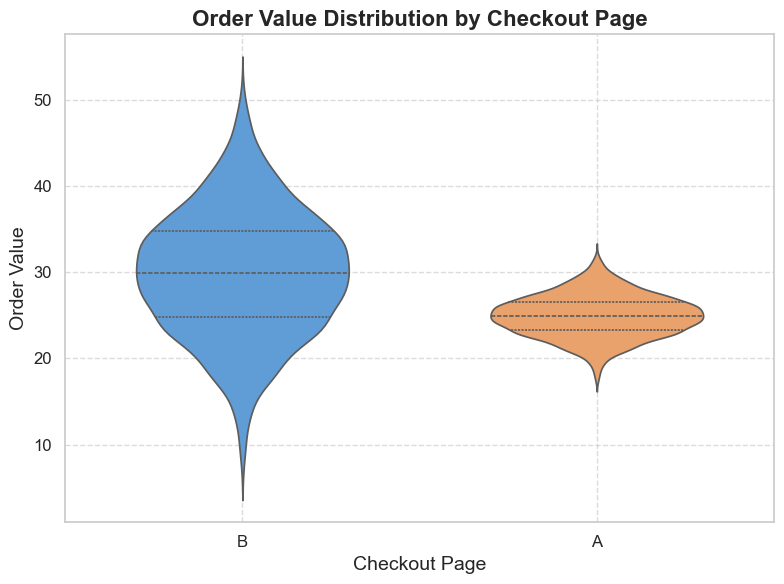

              user_id   order_value                                      
              nunique           sum       mean     median       std count
checkout_page                                                            
A                2260  57501.897808  24.957421  24.955266  2.423809  2304
B                2359  71985.716311  29.894400  29.920530  7.276512  2408
The mean value of orders on Page A is $24.957420923651924
The mean value of orders on Page B is $29.894400461188535


In [279]:
data_unique, page_a_order_value, page_b_order_value, mean_a, mean_b, std_a, std_b, count_a, count_b = preprocessing_data(prior_data)

C:\Users\danrl\AppData\Local\Temp\ipykernel_2392\1401085028.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Checkout Page', title_fontsize=12, fontsize=12)


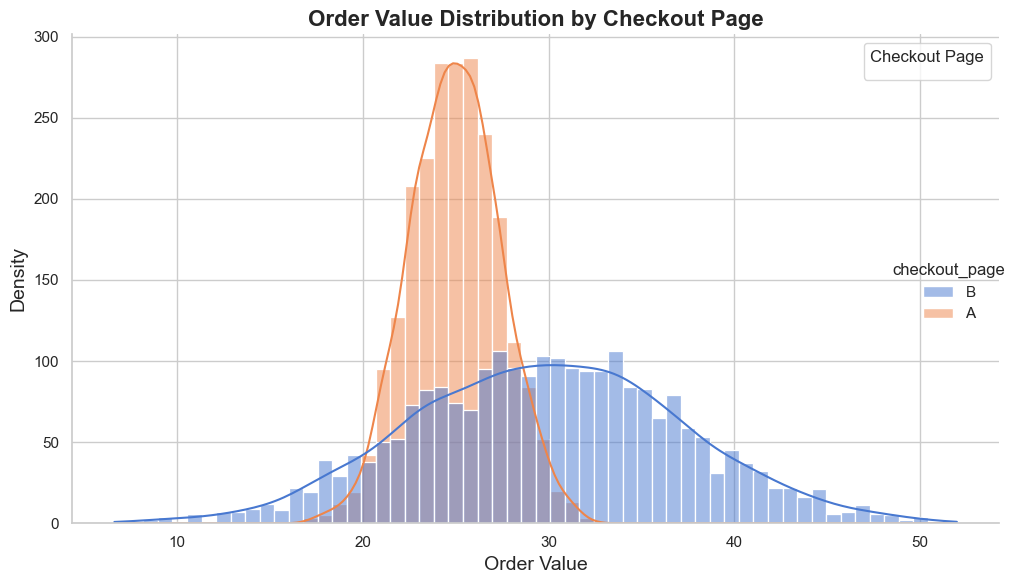

In [285]:
# Set the style
sns.set(style="whitegrid")
palette = sns.color_palette("muted", 2)  # Muted colors for elegance

# Create the displot with KDE (Kernel Density Estimate)
sns.displot(data=data_unique, x="order_value", hue="checkout_page", kde=True, 
            aspect=1.5, height=6, palette=palette)

# Set better labels and title
plt.title('Order Value Distribution by Checkout Page', fontsize=16, fontweight='bold')
plt.xlabel('Order Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Improve legend and remove unnecessary axes
plt.legend(title='Checkout Page', title_fontsize=12, fontsize=12)
plt.tight_layout()

# Show plot
plt.show()

### Shapiro-Wilk test for Normality

Shapiro-Wilk Test: The Shapiro-Wilk test is a statistical test used to assess whether a dataset follows a normal distribution. It calculates a test statistic based on the sample data and compares it to a normal distribution. If the p-value is less than a chosen significance level (usually 0.05), it suggests that the data significantly deviates from normality.

In [281]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

# Verifying normality:
_, p_shapiro_a = shapiro(page_a_order_value)
_, p_shapiro_b = shapiro(page_b_order_value)

print(f"P-valor Shapiro-Wilk Grupo A: {p_shapiro_a:.4f}")
print(f"P-valor Shapiro-Wilk Grupo B: {p_shapiro_b:.4f}")

P-valor Shapiro-Wilk Grupo A: 0.5448
P-valor Shapiro-Wilk Grupo B: 0.5021


In [282]:
if p_shapiro_a > 0.05 and p_shapiro_b > 0.05:
    # If both are normal, use T-test
    t_stat, p_value = ttest_ind(page_a_order_value, page_b_order_value)
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f} (T-test)")
else:
    # If not normal, use Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(page_a_order_value, page_b_order_value)
    print(f"U-statistic: {u_stat}, P-value: {p_value:.4f} (Mann-Whitney U)")

# Checking if the difference is significant
if p_value < 0.05:
    print(f"The difference in order values between pages A and B is statistically significant.")
    
    # Checking which page has the higher mean value
    if mean_a > mean_b:
        print("The average order value on page A is higher than on page B.")
    else:
        print("The average order value on page B is higher than on page A.")
else:
    print("There is no statistically significant difference in order values between pages A and B.")


T-statistic: -30.9648, P-value: 0.0000 (T-test)
The difference in order values between pages A and B is statistically significant.
The average order value on page B is higher than on page A.


#### Mann-Whitney U Test: 
The Mann-Whitney U test is a non-parametric test used to compare two independent samples to determine if they come from the same distribution. It is often used when the data does not follow a normal distribution or when the assumptions for a t-test are not met. It calculates the U statistic and a corresponding p-value, which indicates whether there is a significant difference between the two groups. If the p-value is less than the chosen significance level, the null hypothesis (that the two samples are from the same distribution) is rejected.

### Bayes Inferece (A/B Test)- Part 2:

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 1162 to 212
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     114 non-null    int64  
 1   user_id        114 non-null    int64  
 2   checkout_page  114 non-null    object 
 3   order_value    93 non-null     float64
 4   purchased      114 non-null    float64
 5   gender         114 non-null    object 
 6   browser        114 non-null    object 
 7   time_on_page   114 non-null    float64
dtypes: float64(3), int64(2), object(3)
memory usage: 8.0+ KB
None
The number of values by page: checkout_page
A    68
B    46
Name: count, dtype: int64
checkout_page
1    114
Name: count, dtype: int64
Number of customers who visited only one checkout page: 93
checkout_page
A    54
B    39
Name: count, dtype: int64


C:\Users\danrl\AppData\Local\Temp\ipykernel_2392\3279332595.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)
C:\Users\danrl\AppData\Local\Temp\ipykernel_2392\3279332595.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_unique, x="checkout_page", y="order_value", palette=palette, inner="quart", width=0.6)


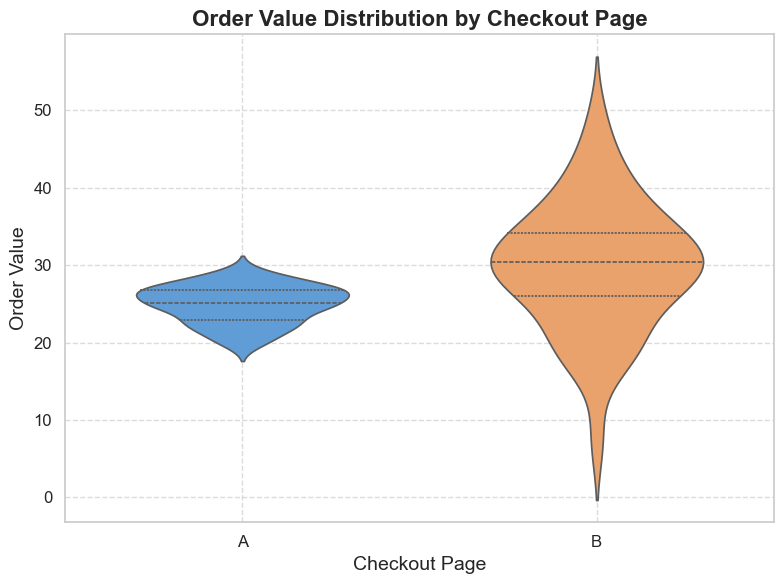

              user_id  order_value                                      
              nunique          sum       mean     median       std count
checkout_page                                                           
A                  54  1347.959410  24.962211  25.166985  2.410079    54
B                  39  1164.259528  29.852808  30.386812  8.211107    39
The mean value of orders on Page A is $24.962211304937696
The mean value of orders on Page B is $29.852808412230914


In [283]:
observed_data_unique, observed_page_a_order_value, observed_page_b_order_value, observed_mean_a, observed_mean_b, observed_std_a, observed_std_b, observed_count_a, observed_count_b = preprocessing_data(observed_data)

C:\Users\danrl\AppData\Local\Temp\ipykernel_2392\1137877174.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Checkout Page', title_fontsize=12, fontsize=12)


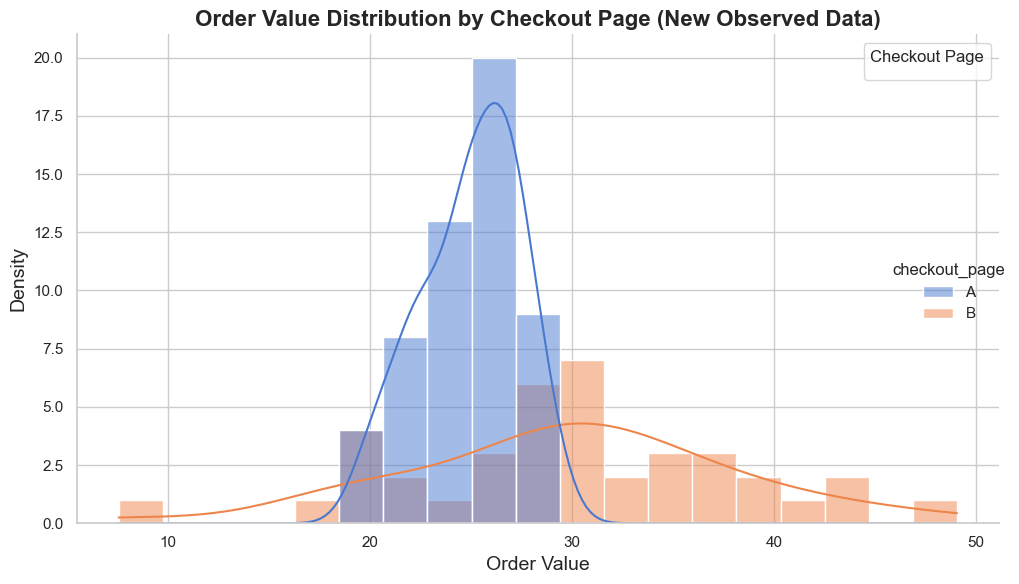

In [284]:
# Set the style
sns.set(style="whitegrid")
palette = sns.color_palette("muted", 2)  # Choose muted colors for elegance

# Create the displot with KDE (Kernel Density Estimate)
sns.displot(data=observed_data_unique, x="order_value", hue="checkout_page", kde=True, 
            aspect=1.5, height=6, palette=palette)

# Set better labels and title
plt.title('Order Value Distribution by Checkout Page (New Observed Data)', fontsize=16, fontweight='bold')
plt.xlabel('Order Value', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Improve legend and remove unnecessary axes
plt.legend(title='Checkout Page', title_fontsize=12, fontsize=12)
plt.tight_layout()

# Show plot
plt.show()

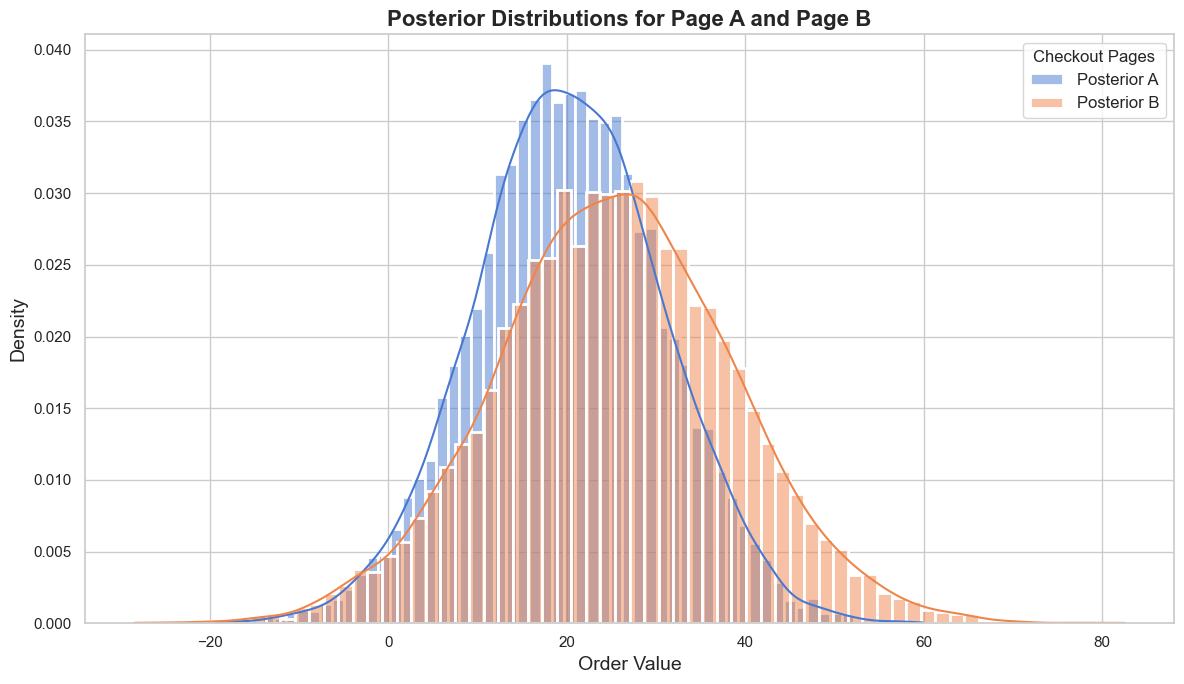

In [216]:
# Using the known data from the first experiment:
# data_unique, page_a_order_value, page_b_order_value, mean_a, mean_b, std_a, std_b, count_a, count_b

# Defining priors for both pages
prior_mean_a = mean_a
prior_scale_a = std_a

prior_mean_b = mean_b
prior_scale_b = std_b

# Function to calculate the posterior using t-Student distribution
def calculate_posterior_t(data, prior_mean, prior_scale, nu=3):
    """
    data: order values (observed sample)
    prior_mean: prior mean
    prior_scale: prior scale (standard deviation)
    nu: degrees of freedom of the t-Student
        - Degrees of freedom (nu) control the shape of the t-distribution.
        - A low nu value (like 3) reflects more uncertainty and heavier tails, allowing for modeling data with higher variability or extreme values.
        - A high nu value makes the t-distribution closer to a normal distribution, indicating less uncertainty about the data's variance.
    """

    # Sample statistics
    n = len(data)
    sample_mean = np.mean(data)
    sample_variance = np.var(data, ddof=1)

    # Updating the posterior parameters
    # Posterior degrees of freedom
    posterior_nu = nu + n
    
    # Posterior Mean (μ_post): The posterior mean is a weighted average between the sample mean and prior mean.
    posterior_mean = (prior_scale * prior_mean + n * sample_mean) / (prior_scale + n)
    
    # Posterior Variance (σ²_post): This term incorporates both the sample variance and the prior uncertainty.
    posterior_scale = np.sqrt((prior_scale**2 * nu + n * sample_variance) / posterior_nu)

    # Generating posterior samples
    posterior_samples = stats.t(df=posterior_nu, loc=posterior_mean, scale=posterior_scale).rvs(10000)
    
    return posterior_samples


# Calculating the posteriors for both pages
posterior_a = calculate_posterior_t(observed_page_a_order_value, prior_mean_a, prior_scale_a)
posterior_b = calculate_posterior_t(observed_page_b_order_value, prior_mean_b, prior_scale_b)

# Set a refined style for the plot
sns.set(style="whitegrid")
palette = sns.color_palette("muted", 2)
plt.figure(figsize=(12, 7))

# Plot the posterior distributions with KDE for Page A and Page B
sns.histplot(posterior_a, kde=True, color=palette[0], label='Posterior A', stat='density', linewidth=2)
sns.histplot(posterior_b, kde=True, color=palette[1], label='Posterior B', stat='density', linewidth=2)

# Customizing:
plt.title('Posterior Distributions for Page A and Page B', fontsize=16, fontweight='bold')
plt.xlabel('Order Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Checkout Pages', title_fontsize=12, fontsize=12)
plt.tight_layout()
plt.show()

**Posterior Calculation (Student's t-distribution) - Mathematical Explanation:**

1. **Posterior Degrees of Freedom** ($\nu_{\text{post}}$):
$$
\nu_{\text{post}} = \nu_{\text{prior}} + n
$$
This value increases with the number of observations, reflecting greater confidence in the posterior distribution.

2. **Posterior Mean** ($\mu_{\text{post}}$):
$$
\mu_{\text{post}} = \frac{\nu_{\text{prior}} \cdot \mu_{\text{prior}} + n \cdot \bar{x}}{\nu_{\text{prior}} + n}
$$
The posterior mean is a weighted average of the sample mean and the prior mean, with more weight given to the sample mean as the sample size increases.

3. **Posterior Variance** ($\sigma^2_{\text{post}}$):
$$
\sigma^2_{\text{post}} = \frac{\nu_{\text{prior}} \cdot \sigma_{\text{prior}}^2 + (n-1) \cdot s^2 + \frac{n(\bar{x} - \mu_{\text{prior}})^2}{\nu_{\text{prior}} + n}}{\nu_{\text{post}}}
$$
The posterior variance incorporates both the sample variance and the uncertainty from the prior. This helps in capturing the overall variability more effectively than using a normal distribution, especially when data has fewer observations or outliers.

**Why not use a Normal Distribution?**

The **t-Student distribution** is preferred when there is uncertainty or small sample sizes, as it captures the tails of the distribution (i.e., outliers) more effectively than a normal distribution. A normal distribution assumes a specific shape (bell curve) and underestimates the variability in small datasets, which is why the t-distribution is more appropriate in such cases.

### Distribution of Differences:
The distribution of differences refers to how the potential differences in average order values between pages A and B are spread out. In a Bayesian context, this distribution shows the range of possible outcomes and their likelihood.

Shape: The distribution may be centered around zero or skewed, depending on the data.
Interpretation: A distribution with most of its mass on the positive side suggests that page B is likely better. Conversely, a distribution centered around zero or with significant mass on both sides implies uncertainty.
Key Metric: The area under the curve (in a specified range) can be used to calculate probabilities, such as the likelihood of one page outperforming the other.
This distribution is essential for determining:

Probability of superiority: How often B beats A.
Credible intervals: The range where differences likely fall.
Risk and expected loss: Quantifying potential downsides

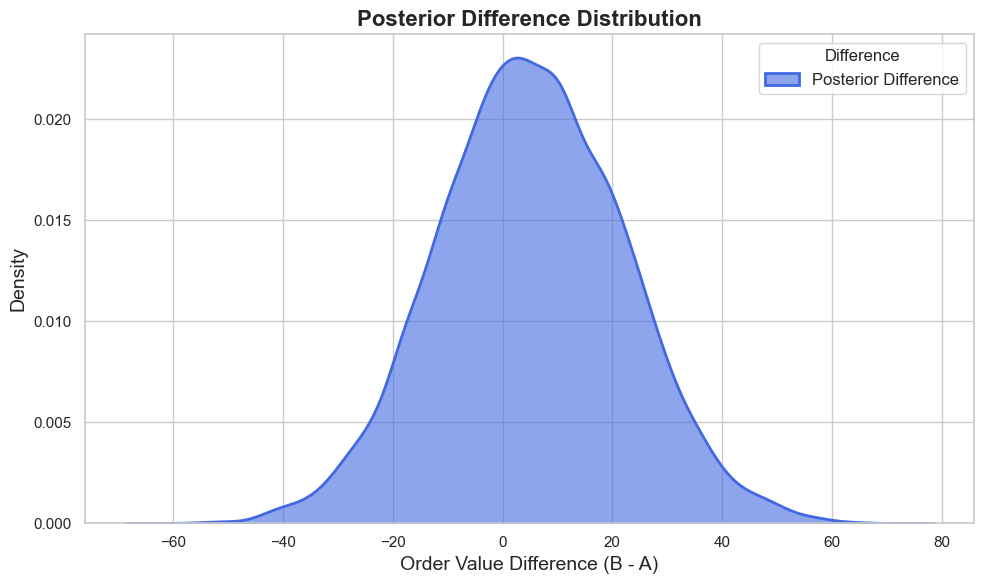

In [288]:
posterior_difference = posterior_b - posterior_a

# Set a refined style for the plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the posterior difference with KDE
sns.kdeplot(posterior_difference, fill=True, color="#4169E1", label="Posterior Difference", linewidth=2, alpha=0.6)

# Adding a title and labels
plt.title('Posterior Difference Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Order Value Difference (B - A)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Difference', title_fontsize=12, fontsize=12)
plt.tight_layout()
plt.show()

### Credible Interval
A credible interval (often referred to as a Bayesian confidence interval) is a range of values within which an unknown parameter (like the difference in order values between pages A and B) is likely to fall, based on the observed data and a prior distribution. It is a central concept in Bayesian statistics.

In simpler terms, it gives you a range of possible values for a parameter, such that, given the data and prior knowledge, there is a specified probability (e.g., 90%) that the true parameter lies within that range.

In [293]:
# Calculating the 90% Highest Density Interval (HDI).
# The HDI represents the range where XX% of the posterior distribution lies.
# This is useful for Bayesian inference, as it provides a credible interval for the difference between the two groups.

hid_prob = 0.9
hdi_interval = az.hdi(posterior_difference, hdi_prob=hid_prob)

# Printing the HDI interval.
# The output will show the lower and upper bounds of the 90% HDI, giving insight into the most credible range of differences.
print(f"HDI (90%): There is a {hid_prob * 100}% of probability that the true difference in order values between the two pages lies within this range: {hdi_interval}")

HDI (90%): There is a 90.0% of probability that the true difference in order values between the two pages lies within this range: [-22.75467959  32.67557561]


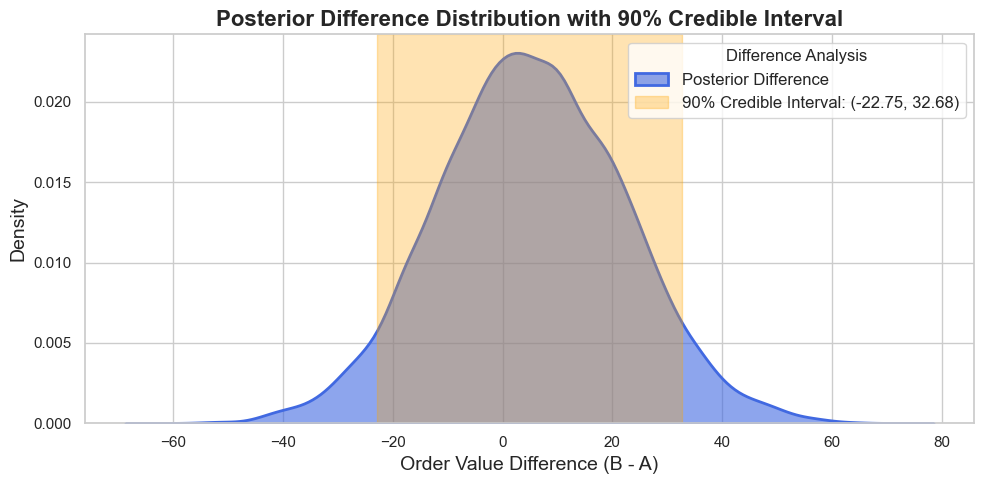

In [242]:
# Set the style for the plot
sns.set(style="whitegrid")

# Calculate the 90% credible interval (CI) for the posterior difference
lower_bound, upper_bound = hdi_interval

# Create a figure with custom size
plt.figure(figsize=(10, 5))

# Plot the posterior difference with KDE
sns.kdeplot(posterior_difference, fill=True, color='#4169E1', label="Posterior Difference", linewidth=2, alpha=0.6)

# Highlight the credible interval (shaded region between the lower and upper bounds)
plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.3, label=f'90% Credible Interval: ({lower_bound:.2f}, {upper_bound:.2f})')

# Title and labels with adjustments for readability
plt.title('Posterior Difference Distribution with 90% Credible Interval', fontsize=16, fontweight='bold')
plt.xlabel('Order Value Difference (B - A)', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Customize legend
plt.legend(title='Difference Analysis', title_fontsize=12, fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

### Probability of one page being better:

In [295]:
prob_b_better = np.mean(posterior_difference > 0)
print(f"The probability of B be better than A is: {prob_b_better:.2%}")

The probability of B be better than A is: 61.42%


### Expected Loss:
The expected loss is the mean of negative differences:

In [297]:
expected_loss = np.mean(np.minimum(posterior_difference, 0))
print(f"The expected loss by choosing the wrong page: {expected_loss}")

The expected loss by choosing the wrong page: -4.493194019592917


### Result's Interpretation
#### Credibility Interval (90% HDI):
The difference in average order values between pages A and B ranges from -21.64 to 30.33. Since the interval includes both negative and positive values, there is no clear and definitive evidence that one page consistently outperforms the other.

#### Probability of B Being Better (62.64%):
There is a 61.66% probability that page B has a higher average order value than page A. This indicates a slight advantage for B, but it is not highly conclusive.

#### Expected Loss (-4.49):
The expected loss from choosing the wrong page is approximately 4.49 monetary units. This means that, on average, if you choose page A when B is actually better (or vice versa), you can expect a loss of 4.31 per order.


------------------------------------------------------ // --------------------------------------------------------------------

#### Practical Interpretation of Loss:
- If we choose A, and B is better: We lose approximately 4.31 monetary units per order. This suggests that, over many orders, this loss could accumulate.
- The decision to switch to page B depends on whether this expected loss justifies the operational and strategic costs of making the change. For instance, if the order volume is high, this accumulated loss could become significant, emphasizing the need for deeper analysis.

#### Contexts where this is relevant:
- High order volume scenarios: Even a small loss per order can have a significant impact on total revenue.
- Marketing and conversion optimization: Understanding the expected loss helps in deciding between different campaigns or checkout strategies.
- Cost-benefit trade-offs: Evaluating whether the expected loss justifies investments in a new implementation.

### ---------------------------------------- // --------------------------------------------------------

### When to Apply Bayesian Methods in A/B Testing and Statistical Analysis:
- When There is Uncertainty or Small Sample Sizes
Bayesian methods allow you to incorporate prior knowledge (priors), stabilizing estimates in scenarios with limited or volatile data.

Example: If you have few clicks or sales in an A/B test, Bayesian inference helps avoid premature conclusions due to high variability.
Practical Scenario: A conversion test with only 100 visitors can benefit from a prior that reflects typical conversion rates (e.g., between 2% and 5%).

- When You Want to Incorporate Relevant Prior Knowledge
If you have historical data or expert knowledge about the behavior of metrics, Bayesian methods can use this as a foundation.

Example: For campaigns with an average purchase value around $20, a Beta or Normal prior can be used to model future campaigns.

- When You Need Full Distributions, Not Just Point Estimates
Bayesian methods provide complete distributions of metrics rather than just averages, giving a clearer understanding of variability and risk.

Example: Instead of stating a 3% conversion rate, you can say there’s an 80% chance it lies between 2% and 4%, aiding better decision-making.

- When Calculating Risk and Expected Loss
Bayesian methods allow you to directly calculate expected loss by considering the distribution of differences between alternatives.

Example: Deciding between two site versions, where one has higher conversion but more variability. Bayesian methods evaluate the trade-off between potential gains and risks.

- For Dynamic Updates with New Data
Bayesian inference lets you update results continuously as new data arrives, without restarting the analysis.

Example: Ongoing monitoring of an A/B test, with daily updates reflecting the latest data.

- When Metrics Do Not Follow Common Distributions (e.g., Normal)
If metrics are skewed or non-Gaussian, Bayesian methods can use flexible distributions to model them.

Example: Churn rates in a subscription service often follow highly skewed distributions, making Bayesian methods ideal.

- For Communicating Results in Probabilistic Terms
Bayesian results are intuitive, directly expressing the probability that one alternative is better.

Example: Saying there’s a 90% chance Version B is better than Version A is more actionable than reporting a p-value.

### Some commom questions about the context:

1. What is an A/B test, and what is its main purpose?
Answer: An A/B test is an experiment that compares two versions of a product or process (e.g., checkout pages or ads) to determine which one performs better based on a specific metric, such as click-through rate or order value.

2. Why did you choose a Bayesian approach for the A/B test instead of a traditional frequentist approach?
Answer: The Bayesian approach allows incorporating prior knowledge (priors) and updating beliefs as new data comes in. It's particularly useful when dealing with small datasets or data that doesn’t follow typical distributions, providing more flexible and robust estimates.

3. What is a "prior distribution," and how is it used in a Bayesian model?
Answer: A prior distribution represents what we know or assume about a parameter before seeing the current data. For example, in an A/B test, it could reflect expectations about the click-through rate based on past tests. It’s updated with new data to form the posterior distribution.

4. How do you calculate the posterior distribution in a Bayesian A/B test?
Answer: The posterior distribution is calculated by combining the likelihood of the observed data with the prior distribution, using Bayes' theorem. For example, in code, we update a prior (e.g., Beta) with observed successes and trials to obtain the posterior.

5. Why is calculating the credible interval (HDI) important in a Bayesian A/B test?
Answer: The HDI (Highest Density Interval) provides the range of values where the parameter is most likely to fall, given the data and prior. Unlike frequentist confidence intervals, the HDI directly represents the probability of the parameter being within the interval.

6. How do you interpret the 61.66% probability that Page B is better?
Answer: It means there is a 61.66% chance that Page B performs better than Page A in terms of average order value, given the data and prior. This indicates a higher likelihood of B being more effective but not a certainty.

7. Why is the expected loss negative, and how do you interpret it?
Answer: A negative expected loss indicates that choosing Page A instead of Page B would result in a financial loss. The value of -$4.31 means that, on average, each transaction would generate $4.31 less if Page A were chosen over Page B.

8. What is the benefit of splitting the dataset to create priors and posteriors in a Bayesian context?
Answer: Splitting the dataset allows using historical data to form a prior and updating it with more recent observations to generate the posterior. This approach leverages previous knowledge while adapting to current conditions, improving decision-making.

9. How do you handle non-normal distributions in a Bayesian A/B test?
Answer: Instead of assuming a normal distribution, you can choose a prior and likelihood that better match the data. For example, if the data follows a t-distribution, you can use a t-distribution likelihood or alternative priors like Beta or Gamma.

10. What are the challenges of applying Bayesian methods to large datasets?
Answer: Bayesian methods can be computationally expensive for large datasets due to the complexity of updating priors and calculating posteriors. Techniques like MCMC (Markov Chain Monte Carlo) may be required but can be slow. Frequentist methods may be more efficient in such cases.

### Bayes' Theorem

$$
P(\theta \mid \text{data}) = \frac{P(\text{data} \mid \theta) \cdot P(\theta)}{P(\text{data})}
$$

#### Explanation of Terms:

\[
\begin{align*}
P(\theta \mid \text{data}) &: \text{Posterior Probability — Updated belief about the parameter } \theta \text{ after observing the data.} \\
P(\text{data} \mid \theta) &: \text{Likelihood — Probability of the observed data given the parameter } \theta. \\
P(\theta) &: \text{Prior Probability — Initial belief about the parameter } \theta \text{ before observing the data.} \\
P(\text{data}) &: \text{Marginal Likelihood — Normalizing constant, representing the total probability of the data under all possible parameter values.}
\end{align*}
\]